# Searching for elementary particles with Neural Networks (Learning rate, Dropout and Regularization)
### The data we will use comes from a research where the potential of neural networks in the search for new particles in physics was examined: Baldi, P., Sadowski, P. & Whiteson, D. Searching for exotic particles in high-energy physics with deep learning. Nat Commun 5, 4308 (2014). https://doi.org/10.1038/ncomms5308.
### The goal is to classify between two classes (if there is a clue or not) based on 28 features.

In [1]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

tf.random.set_seed(0) # for replicability purposes, not for production

* The dataset is available from <https://archive.ics.uci.edu/ml/datasets/HIGGS>. We for practical reasons will use a subset of 13,000 samples.

In [2]:
higgs_data = pd.read_csv("higgs.csv", dtype=float)
higgs_data

,label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,...,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,0.0,0.915045,-0.318542,0.623526,0.431166,1.338325,0.641709,-0.750620,1.153816,2.173076,...,-0.691704,-0.797121,0.000000,0.662336,0.888811,0.994402,0.876122,1.207429,0.790956,0.733438
12996,0.0,1.076093,0.377846,0.301706,0.297954,-1.517734,0.715086,1.019911,-1.453517,2.173076,...,-0.261967,0.204601,3.101961,1.031421,0.828652,0.986768,0.845410,1.701100,1.004952,0.854111
12997,1.0,1.296986,-1.198036,0.437647,1.742790,-0.218009,2.283859,-0.934802,1.201492,0.000000,...,-0.142873,1.619627,0.000000,1.124735,2.031752,1.159143,0.975911,1.069575,1.566676,1.410350
12998,1.0,1.151859,-0.981815,-1.661498,0.741689,0.353002,0.667175,0.204952,0.488566,2.173076,...,-0.825788,-0.094044,1.550981,0.973411,0.997322,1.242204,0.739249,0.681640,0.757485,0.812424


* We will take 11,000 samples for training and validation and use 2,000 samples for testing.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(higgs_data.iloc[:, 1:], 
                                                    higgs_data.iloc[:, 0], 
                                                    train_size=11000)

* We will ensure that attribute values ​​have a mean of zero and a variance of one.

In [4]:
normalizer = layers.Normalization()
normalizer.adapt(np.array(X_train))

2022-03-17 15:54:13.209026: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* In our model we will use an activation function that we have never seen before, the Exponential Linear Unit, ELU (Exponential Linear Unit):

$$
  f(x) = 
  \begin{cases} 
   x &  x > 0 \\
   \alpha (e^{x} - 1) &  x \le 0
  \end{cases}
$$

* ELU differs from ReLU in that it is smoother near the zero point and in addition can give a negative output.

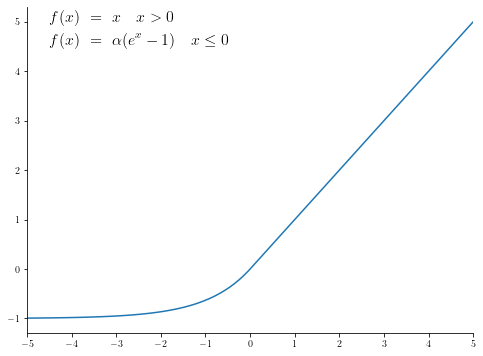

In [5]:
plt.rcParams["text.usetex"] = True

elu_label = (
    r"\begin{eqnarray*}"
    r"f(x) &=& x \quad x > 0 \\"
    r"f(x) &=& \alpha (e^{x} - 1)\quad  x \le 0"
    r"\end{eqnarray*}"
)
fig = plt.figure(figsize=(8, 6))
ax = plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim((-5, 5))
plt.xticks(np.arange(-5, 6, 1))
x = np.linspace(-5, 5, 100)
y = np.zeros_like(x)
y = x.copy()
alpha = 1
y[0:50] = alpha * (np.exp(x[0:50]) - 1)
ax.text(-4.5, 5, elu_label, color="k", fontsize=16)
_ = plt.plot(x, y)

* We will define the number of epochs, the size of each bin, and from there the number of training steps in each epoch.

In [6]:
NUM_EPOCHS = 10000
BATCH_SIZE = 100
STEPS_PER_EPOCH = X_train.shape[0] // BATCH_SIZE

* An important hyperparameter in neural networks is the *learning rate*.

* This defines how large the corrections made to weights and biases will be at each step of learning.

* If the learning rate is large, then the corrections are large, and the network learns quickly.

* On the other hand, it can be "careless": the corrections are so large that it deviates from the optimal values ​​of the weights and biases.

* If the learning rate is small, then the corrections are smaller, the network learns more conservatively, and it takes longer to train.

* One way to approach this is to think about what happens in golf.

* At the beginning the player is far from the hole and his strokes will be strong so that the ball will approach the hole quickly.

* But when he gets closer to the hole, the player becomes more careful. If he keeps hitting the same way, the ball will just go the other way.

* If we use the Adam optimizer (or others), we can set a variable learning rate.

* Specifically, we will define a *learning schedule* (learning schedule), in which the learning rate will gradually decrease.

* The idea is that initially we want our neural network to learn quickly, but as training progresses we want it to become more careful.

* Using the `InverseTimeDecay` class we define that we will start with an initial learning rate and then every 100 epochs it will decrease so that at 100 epochs it becomes 1/2 of the original, at 200 1/3 of the original, and so on. Mr.

In [7]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH * 100,
  decay_rate=1,
  staircase=False)

step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

* We are now building our model, where we will use as in the original post layers of 300 neurons.

* In the end we will have a layer with a sigmoid activation function, since we want classification between two classes.

* The loss will be calculated through the `BinaryCrossentropy` class and as metrics we will have `BinaryAccuracy` and `BinaryCrossEntropy` (we will come back to this point later).

In [9]:
model = keras.Sequential([
    normalizer,
    layers.Dense(300, activation='elu'),
    layers.Dense(300, activation='elu'),
    layers.Dense(300, activation='elu'),    
    layers.Dense(300, activation='elu'),
    layers.Dense(300, activation='elu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(lr_schedule),
              metrics=[
                  tf.keras.losses.BinaryCrossentropy(from_logits=False, name='binary_crossentropy'),
                  tf.metrics.BinaryAccuracy(threshold=0.5)
              ])

* Let's see it briefly.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 28)               57        
 n)                                                              
                                                                 
 dense (Dense)               (None, 300)               8700      
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 dense_2 (Dense)             (None, 300)               90300     
                                                                 
 dense_3 (Dense)             (None, 300)               90300     
                                                                 
 dense_4 (Dense)             (None, 300)               90300     
                                                        

* We will train our model up to 10000 epochs.

* Instead of showing progress per epoch (too many), we will display progress per 100 epochs, and each completed epoch will simply print a dot.

* To do this we will define a class of our own that we will give to TensorFlow as a callback.

In [11]:
# From https://github.com/tensorflow/docs/blob/master/tools/tensorflow_docs/modeling/__init__.py
class EpochDots(tf.keras.callbacks.Callback):
    """A simple callback that prints a "." every epoch, with occasional reports.
    
    Args:
        report_every: How many epochs between full reports
        dot_every: How many epochs between dots.
    """

    def __init__(self, report_every=100, dot_every=1):
        self.report_every = report_every
        self.dot_every = dot_every

    def on_epoch_end(self, epoch, logs):
        if epoch % self.report_every == 0:
            print()
            print('Epoch: {:d}, '.format(epoch), end='')
            for name, value in sorted(logs.items()):
                print('{}:{:0.4f}'.format(name, value), end=',  ')
            print()

        if epoch % self.dot_every == 0:
            print('.', end='', flush=True)

* And now we proceed to training.

In [12]:
early_stop = [
    EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
]

history = model.fit(
    X_train, 
    y_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=0,
    callbacks=early_stop)


Epoch: 0, binary_accuracy:0.6108,  binary_crossentropy:0.6605,  loss:0.6605,  val_binary_accuracy:0.6345,  val_binary_crossentropy:0.6304,  val_loss:0.6304,  
....................................................................................................
Epoch: 100, binary_accuracy:1.0000,  binary_crossentropy:0.0000,  loss:0.0000,  val_binary_accuracy:0.6764,  val_binary_crossentropy:2.8128,  val_loss:2.8128,  
....................................................................................................
Epoch: 200, binary_accuracy:1.0000,  binary_crossentropy:0.0000,  loss:0.0000,  val_binary_accuracy:0.6773,  val_binary_crossentropy:4.0083,  val_loss:4.0083,  
...........

* We can see the progress if we make a helper function for the visualization.

In [13]:
def plot_loss(history):
    plt.plot(history.history['binary_crossentropy'], label='training')
    plt.plot(history.history['val_binary_crossentropy'], label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Crossentropy')
    plt.legend()
    plt.grid(True)

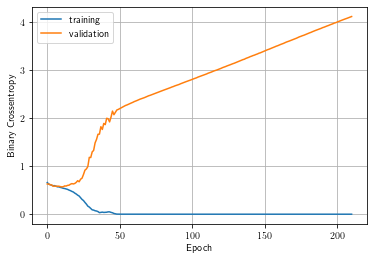

In [14]:
plot_loss(history)

* The results are a tragedy.

* Very quickly the loss in validation shoots up.

* This is a clear indication of overfitting.

* One way to combat underfitting in neural networks is through *dropout*.

* The [idea behind dropout](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout) is that at each training step, nodes are "dropped" with probability $p$ or retained with probability $1 - p$.

* In practice, that is, we harvest from the neural network the nodes with probability $p$.

* In the next step of training, the nodes to be discarded are again randomly selected, so some will be re-entered and some others will be exited.

In [15]:
model = keras.Sequential([
    normalizer,
    layers.Dense(300, input_shape=(X_train.shape[1],), activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(300, activation='elu'),
    layers.Dropout(0.5),    
    layers.Dense(300, activation='elu'),
    layers.Dropout(0.5),    
    layers.Dense(300, activation='elu'),
    layers.Dropout(0.5),    
    layers.Dense(300, activation='elu'),
    layers.Dropout(0.5),    
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(lr_schedule),
              metrics=[
                  tf.keras.losses.BinaryCrossentropy(from_logits=False, name='binary_crossentropy'),
                  tf.metrics.BinaryAccuracy(threshold=0.5)
              ])

In [16]:
history = model.fit(
    X_train, 
    y_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=0,
    callbacks=early_stop)


Epoch: 0, binary_accuracy:0.5403,  binary_crossentropy:0.7985,  loss:0.7985,  val_binary_accuracy:0.6009,  val_binary_crossentropy:0.6457,  val_loss:0.6457,  
....................................................................................................
Epoch: 100, binary_accuracy:0.7028,  binary_crossentropy:0.5649,  loss:0.5649,  val_binary_accuracy:0.7100,  val_binary_crossentropy:0.5590,  val_loss:0.5590,  
....................................................................................................
Epoch: 200, binary_accuracy:0.7251,  binary_crossentropy:0.5310,  loss:0.5310,  val_binary_accuracy:0.7018,  val_binary_crossentropy:0.5690,  val_loss:0.5690,  
.................................................................................

* We see that the situation has somewhat improved.

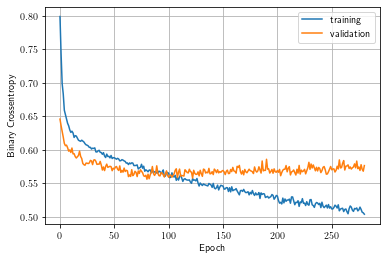

In [17]:
plot_loss(history)

* Another idea to avoid overfitting is *normalization* (regularization).

* In this approach, we reduce the weights to zero.

* The reason is that the fewer weights in the final model, the fewer parameters we have in the end, so the leaner the final model is.

* In L1 normalization, we add to the loss an amount proportional to the absolute value of each weight. The result is that some weights are zeroed out.

* In L2 normalization, we add to the loss an amount proportional to the square of each weight. The result is to minimize (but not completely eliminate) some weights.

* In particular, if we use `regularizers.l2(0.001)`, as below, each weight will add $0{,}001 \times w^2$ to the network loss.

* This is also why we track the `binary_crossentropy` metric and not just the loss, because we don't want to consider normalization.

* Now in output, `binary_crossentropy`, `val_binary_cross_entropy` will differ from `loss` and `val_loss`.

In [18]:
model = keras.Sequential([
    normalizer,
    layers.Dense(300, input_shape=(X_train.shape[1],),
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(300,
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(300,
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(300,
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(300,
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(lr_schedule),
              metrics=[
                  tf.keras.losses.BinaryCrossentropy(from_logits=False, name='binary_crossentropy'),
                  tf.metrics.BinaryAccuracy(threshold=0.5)
              ])

In [19]:
history = model.fit(
    X_train, 
    y_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=0,
    callbacks=early_stop)


Epoch: 0, binary_accuracy:0.6091,  binary_crossentropy:0.6573,  loss:1.6072,  val_binary_accuracy:0.6527,  val_binary_crossentropy:0.6129,  val_loss:1.2987,  
....................................................................................................
Epoch: 100, binary_accuracy:0.7159,  binary_crossentropy:0.5559,  loss:0.5803,  val_binary_accuracy:0.7136,  val_binary_crossentropy:0.5623,  val_loss:0.5866,  
....................................................................................................
Epoch: 200, binary_accuracy:0.7296,  binary_crossentropy:0.5328,  loss:0.5600,  val_binary_accuracy:0.7064,  val_binary_crossentropy:0.5754,  val_loss:0.6024,  
....................................................................................................
Epoch: 300, binary_accuracy:0.7384,  binary_crossentropy:0.5164,  loss:0.5456,  val_binary_accuracy:0.7064,  val_binary_crossentropy:0.5826,  val_loss:0.6115,  
.............................

* We see that normalization can also help.

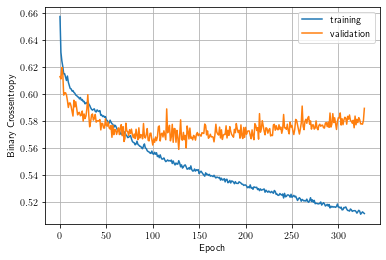

In [20]:
plot_loss(history)

* So the next logical step is to combine both methods to avoid overfitting.

In [21]:
model = keras.Sequential([
    normalizer,
    layers.Dense(300, input_shape=(X_train.shape[1],),
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(300,
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dropout(0.5),    
    layers.Dense(300,
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dropout(0.5),    
    layers.Dense(300,
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dropout(0.5),    
    layers.Dense(300,
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dropout(0.5),    
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(lr_schedule),
              metrics=[
                  tf.keras.losses.BinaryCrossentropy(from_logits=False, name='binary_crossentropy'),
                  tf.metrics.BinaryAccuracy(threshold=0.5)
              ])

In [22]:
history = model.fit(
    X_train, 
    y_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=0,
    callbacks=early_stop)


Epoch: 0, binary_accuracy:0.5331,  binary_crossentropy:0.7987,  loss:1.9778,  val_binary_accuracy:0.5973,  val_binary_crossentropy:0.6548,  val_loss:1.7612,  
....................................................................................................
Epoch: 100, binary_accuracy:0.6637,  binary_crossentropy:0.6170,  loss:0.6461,  val_binary_accuracy:0.6682,  val_binary_crossentropy:0.5974,  val_loss:0.6261,  
....................................................................................................
Epoch: 200, binary_accuracy:0.6684,  binary_crossentropy:0.6141,  loss:0.6409,  val_binary_accuracy:0.6745,  val_binary_crossentropy:0.5999,  val_loss:0.6268,  
....................................................................................................
Epoch: 300, binary_accuracy:0.6737,  binary_crossentropy:0.6140,  loss:0.6398,  val_binary_accuracy:0.6700,  val_binary_crossentropy:0.5953,  val_loss:0.6206,  
......................................................

* We achieved even better behavior.

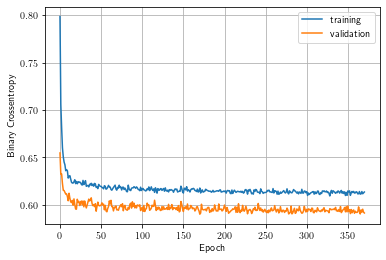

In [23]:
plot_loss(history)

* We can additionally evaluate our model based on control data.

In [24]:
metrics = model.evaluate(X_test, y_test, verbose=0)
for metric_name, metric in zip(model.metrics_names, metrics):
    print(metric_name, metric)

loss 0.6162694692611694
binary_crossentropy 0.5913078188896179
binary_accuracy 0.6830000281333923


* Applying the right strategy to avoid overfitting is a key ingredient to success in a neural network model.

* Our tools allow us to stack layers upon layers.

* This does not mean that this is how we will solve the problem.

* We must always be careful to use properly the power given to us by the tools we have in our hands.